In [1]:
library('tidyverse')
library("hise")
library('data.table')
library('parallel')
library('dplyr')
library(patchwork)
library(ggplot2)
library(arrow)
library(Seurat)

set.seed(123)

Sys.setenv( TZ="Etc/GMT+1")
options(warn = -1)

Warning message:
“package ‘tidyverse’ was built under R version 4.3.3”
Warning message:
“package ‘tibble’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.3”
Warning message:
“package ‘readr’ was built under R version 4.3.3”
Warning message:
“package ‘purrr’ was built under R version 4.3.3”
Warning message:
“package ‘dplyr’ was built under R version 4.3.3”
Warning message:
“package ‘stringr’ was built under R version 4.3.3”
Warning message:
“package ‘forcats’ was built under R version 4.3.3”
Warning message:
“package ‘lubridate’ was built under R version 4.3.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()

In [2]:
adata<-anndata::read_h5ad("/home//workspace/IHA_Review_Analysis/Other_Analysis/06_TEAseq_Day0/TEA_scRNA_all.h5ad")

In [3]:
pbmc<-CreateSeuratObject(t(adata$X), project = "SeuratProject", assay = "RNA",
  min.cells = 0, min.features = 0, names.field = 1,
  names.delim = "_", meta.data = adata$obs)

In [4]:
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)

Normalizing layer: counts



# Pseudo Time 1

In [40]:
pesudo_time_df<-as.data.frame(read_parquet('pesudo_time_df.csv'))
pesudo_time_df<-pesudo_time_df[!is.na(pesudo_time_df$AIFI_L3),]
pesudo_time_df <- pesudo_time_df %>%
  mutate(cohort.x = case_when(
    startsWith(subject_id.ch1, "BR2") ~ "BR2",
    TRUE ~ 'UP1' 
  ))

## RNA

In [42]:
dense_matrix <- as.matrix(pbmc@assays$RNA$data[c("LEF1", "TCF7", "ITGB1","GZMK","GZMB", "GZMA", "GZMH"),])
df <- as.data.frame(dense_matrix)

In [43]:
df_scRNA<-as.data.frame(t(df))
df_scRNA$barcodes_scRNA<-rownames(df_scRNA)

In [44]:
pesudo_time_df<-left_join(pesudo_time_df,df_scRNA,by=c("X.x"="barcodes_scRNA"))

In [45]:
subset_data <- pesudo_time_df[sample(nrow(pesudo_time_df), size = 10000), ]  %>% filter(grepl("1",curve.assignments))

In [46]:
p_list <- list()
matched_cols<-c("LEF1", "TCF7", "ITGB1","GZMK","GZMB", "GZMA", "GZMH")
for (i in matched_cols) {
    is_last <- i == tail(matched_cols, 1)

p_list[[i]]<-ggplot(subset_data, aes(pesudo_time_1, !!as.name(i))) +
    geom_smooth(method = "loess", se = FALSE)+
  theme_linedraw()  +
  labs(
    y = NULL,  # Remove the left y-axis title
    x = if (is_last) "pesudo_time" else NULL
  )+
  theme(
    axis.title.x = if (is_last) element_text() else element_blank(),
    axis.text.x = if (is_last) element_text() else element_blank(),
    axis.ticks.x = if (is_last) element_line() else element_blank(),
    axis.title.y = element_blank(), 
    axis.title.y.right = element_text(size = 10, angle = 90), 
    axis.text.y.right = element_blank(),
    axis.ticks.y.right = element_blank()
  ) +
  scale_y_continuous(
    sec.axis = sec_axis(~., name = i)
  ) +
  theme(plot.margin = margin(0, 0, 0, -1.2, "cm")) +
  xlim(0, 22)

}

In [47]:
summary_range<-subset_data %>% group_by(AIFI_L3) %>% summarize(
  max_range = quantile(pesudo_time_1, 0.95),
  min_range = quantile(pesudo_time_1, 0.05)
)

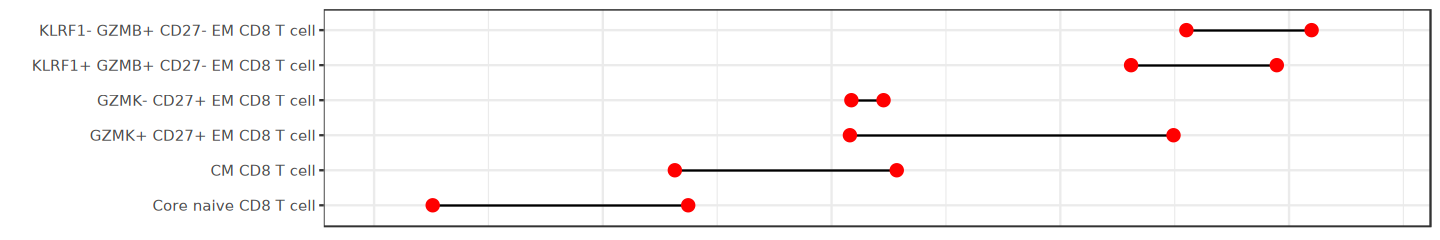

In [48]:
options(repr.plot.width = 12, repr.plot.height =2)

p1<-ggplot(
  summary_range %>% mutate(AIFI_L3 = fct_reorder(AIFI_L3, min_range)), 
  aes(x = AIFI_L3)
)+  geom_linerange(aes(ymin = min_range, ymax = max_range), linetype = 1, color = "black") +
  geom_point(aes(y = min_range), size = 3, color = "red") +
  geom_point(aes(y = max_range), size = 3, color = "red") +
  theme_bw() +
  coord_flip()+xlab("")+ylab("")+
    theme(
      axis.title.x =  element_blank(),
      axis.text.x =  element_blank(),
      axis.ticks.x =  element_blank()
    ) +ylim(0,22)
p1

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


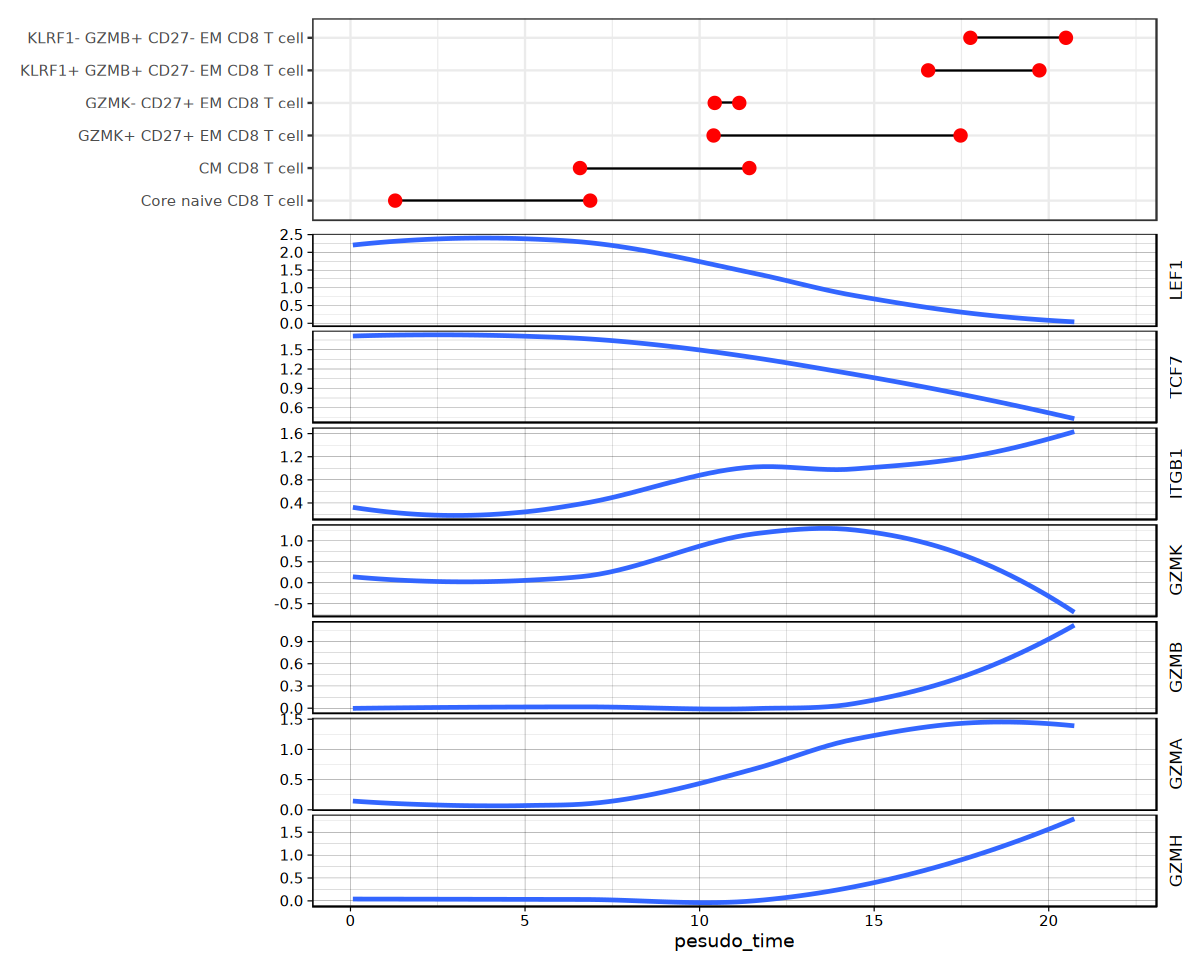

In [50]:
options(repr.plot.width = 10, repr.plot.height =8)

p_combined<-wrap_plots(p_list,ncol=1)+ 
  plot_layout(guides = "collect")

p1 / p_combined+ plot_layout(heights = c(0.15, 0.5))

## ADT


In [ ]:
adt_adata=anndata::read_h5ad("/home//workspace/IHA_Review_Analysis/Other_Analysis/06_TEAseq_Day0/ADT_All.h5ad")

In [ ]:
df_ADT<-as.data.frame(adt_adata$X)
colnames(df_ADT)<-paste0("ADT_",colnames(df_ADT))

In [ ]:
df_ADT$barcodes_scRNA<-rownames(df_ADT)

In [ ]:
pesudo_time_df <- pesudo_time_df[, !grepl("ADT", colnames(pesudo_time_df))]

In [ ]:
pesudo_time_df<-left_join(pesudo_time_df,df_ADT,by=c("X.x"="barcodes_scRNA"))

In [ ]:
subset_data <- pesudo_time_df[sample(nrow(pesudo_time_df), size = 10000), ]   %>% filter(grepl("1",curve.assignments))

In [ ]:
p_list <- list()
matched_cols<-paste0("ADT_",c("CD45RA", "CD197", "CD27", "CD95", "CD49d"))
for (i in matched_cols) {
    is_last <- i == tail(matched_cols, 1)

p_list[[i]]<-ggplot(subset_data, aes(pesudo_time_1, !!as.name(i))) +
    geom_smooth(method = "loess", se = FALSE)+
  theme_linedraw()  +
  labs(
    y = NULL,  # Remove the left y-axis title
    x = if (is_last) "pesudo_time" else NULL
  )+
  theme(
    axis.title.x = if (is_last) element_text() else element_blank(),
    axis.text.x = if (is_last) element_text() else element_blank(),
    axis.ticks.x = if (is_last) element_line() else element_blank(),
    axis.title.y = element_blank(), # Remove title from the left
    axis.title.y.right = element_text(size = 10, angle = 90), # Add title to the right
    axis.text.y.right = element_blank(), # Remove text on the right
    axis.ticks.y.right = element_blank() # Remove ticks on the right
  ) +
  scale_y_continuous(
    sec.axis = sec_axis(~., name = i)
  ) +
  theme(plot.margin = margin(0, 0, 0, -1.2, "cm")) +
  xlim(0, 22)

}

In [ ]:
summary_range<-subset_data %>% group_by(AIFI_L3) %>% summarize(
  max_range = quantile(pesudo_time_1, 0.95),
  min_range = quantile(pesudo_time_1, 0.05)
)

In [ ]:
options(repr.plot.width = 12, repr.plot.height =2)

p1<-ggplot(
  summary_range %>% mutate(AIFI_L3 = fct_reorder(AIFI_L3, min_range)), 
  aes(x = AIFI_L3)
)+  geom_linerange(aes(ymin = min_range, ymax = max_range), linetype = 1, color = "black") +
  geom_point(aes(y = min_range), size = 3, color = "red") +
  geom_point(aes(y = max_range), size = 3, color = "red") +
  theme_bw() +
  coord_flip()+xlab("")+ylab("")+
    theme(
      axis.title.x =  element_blank(),
      axis.text.x =  element_blank(),
      axis.ticks.x =  element_blank()
    ) +ylim(0,22)
p1

In [ ]:
options(repr.plot.width = 10, repr.plot.height =8)

p_combined<-wrap_plots(p_list,ncol=1)+ 
  plot_layout(guides = "collect")

p1 / p_combined+ plot_layout(heights = c(0.15, 0.5))

# Pseudo Time 2

In [ ]:
pesudo_time_df<-as.data.frame(read_parquet('pesudo_time_df.csv'))
pesudo_time_df<-pesudo_time_df[!is.na(pesudo_time_df$AIFI_L3),]
pesudo_time_df <- pesudo_time_df %>%
  mutate(cohort.x = case_when(
    startsWith(subject_id.ch1, "BR2") ~ "BR2",
    TRUE ~ 'UP1' 
  ))

## RNA

In [ ]:
dense_matrix <- as.matrix(pbmc@assays$RNA$data[c("LEF1", "TCF7", "ITGB1"),])
df <- as.data.frame(dense_matrix)

In [ ]:
df_scRNA<-as.data.frame(t(df))
df_scRNA$barcodes_scRNA<-rownames(df_scRNA)

In [ ]:
pesudo_time_df<-left_join(pesudo_time_df,df_scRNA,by=c("X.x"="barcodes_scRNA"))

In [ ]:
subset_data <- pesudo_time_df[sample(nrow(pesudo_time_df), size = 10000), ]  %>% filter(grepl("2",curve.assignments))

In [ ]:
p_list <- list()
matched_cols<-c("LEF1", "TCF7", "ITGB1")
for (i in matched_cols) {
    is_last <- i == tail(matched_cols, 1)

p_list[[i]]<-ggplot(subset_data, aes(pesudo_time_2, !!as.name(i))) +
    geom_smooth(method = "loess", se = FALSE)+
  theme_linedraw()  +
  labs(
    y = NULL,  # Remove the left y-axis title
    x = if (is_last) "pesudo_time" else NULL
  )+
  theme(
    axis.title.x = if (is_last) element_text() else element_blank(),
    axis.text.x = if (is_last) element_text() else element_blank(),
    axis.ticks.x = if (is_last) element_line() else element_blank(),
    axis.title.y = element_blank(), # Remove title from the left
    axis.title.y.right = element_text(size = 10, angle = 90), # Add title to the right
    axis.text.y.right = element_blank(), # Remove text on the right
    axis.ticks.y.right = element_blank() # Remove ticks on the right
  ) +
  scale_y_continuous(
    sec.axis = sec_axis(~., name = i)
  ) +
  theme(plot.margin = margin(0, 0, 0, -1.2, "cm")) +
  xlim(0, 22)

}

In [ ]:
summary_range<-subset_data %>% group_by(AIFI_L3) %>% summarize(
  max_range = quantile(pesudo_time_1, 0.95),
  min_range = quantile(pesudo_time_1, 0.05)
)

In [ ]:
options(repr.plot.width = 12, repr.plot.height =2)

p1<-ggplot(
  summary_range %>% mutate(AIFI_L3 = fct_reorder(AIFI_L3, min_range)), 
  aes(x = AIFI_L3)
)+  geom_linerange(aes(ymin = min_range, ymax = max_range), linetype = 1, color = "black") +
  geom_point(aes(y = min_range), size = 3, color = "red") +
  geom_point(aes(y = max_range), size = 3, color = "red") +
  theme_bw() +
  coord_flip()+xlab("")+ylab("")+
    theme(
      axis.title.x =  element_blank(),
      axis.text.x =  element_blank(),
      axis.ticks.x =  element_blank()
    ) +ylim(0,22)
p1

In [ ]:
options(repr.plot.width = 10, repr.plot.height =4)

p_combined<-wrap_plots(p_list,ncol=1)+ 
  plot_layout(guides = "collect")

p1 / p_combined+ plot_layout(heights = c(0.15, 0.5))

## ADT


In [ ]:
adt_adata=anndata::read_h5ad("/home//workspace/IHA_Review_Analysis/Other_Analysis/06_TEAseq_Day0/ADT_All.h5ad")

In [ ]:
df_ADT<-as.data.frame(adt_adata$X)
colnames(df_ADT)<-paste0("ADT_",colnames(df_ADT))

In [ ]:
df_ADT$barcodes_scRNA<-rownames(df_ADT)

In [ ]:
pesudo_time_df <- pesudo_time_df[, !grepl("ADT", colnames(pesudo_time_df))]

In [ ]:
pesudo_time_df<-left_join(pesudo_time_df,df_ADT,by=c("X.x"="barcodes_scRNA"))

In [ ]:
subset_data <- pesudo_time_df[sample(nrow(pesudo_time_df), size = 10000), ]   %>% filter(grepl("1",curve.assignments))
ggplot(subset_data, aes(pesudo_time_1, !!as.name('ADT_CD45RA'))) +
    geom_smooth(method = "loess", se = FALSE)+
  theme_linedraw()  +geom_point()

In [ ]:
subset_data <- pesudo_time_df[sample(nrow(pesudo_time_df), size = 10000), ]   %>% filter(grepl("2",curve.assignments))
ggplot(subset_data, aes(pesudo_time_2, !!as.name('ADT_CD45RA'))) +
    geom_smooth(method = "loess", se = FALSE)+
  theme_linedraw()  +geom_point()

In [ ]:
p_list <- list()
matched_cols<-paste0("ADT_",c("CD45RA", "CD197", "CD27", "CD95", "CD49d"))
for (i in matched_cols) {
    is_last <- i == tail(matched_cols, 1)

p_list[[i]]<-ggplot(subset_data, aes(pesudo_time_2, !!as.name(i))) +
    geom_smooth(method = "loess", se = FALSE)+
  theme_linedraw()  +
  labs(
    y = NULL,  # Remove the left y-axis title
    x = if (is_last) "pesudo_time" else NULL
  )+
  theme(
    axis.title.x = if (is_last) element_text() else element_blank(),
    axis.text.x = if (is_last) element_text() else element_blank(),
    axis.ticks.x = if (is_last) element_line() else element_blank(),
    axis.title.y = element_blank(), # Remove title from the left
    axis.title.y.right = element_text(size = 10, angle = 90), # Add title to the right
    axis.text.y.right = element_blank(), # Remove text on the right
    axis.ticks.y.right = element_blank() # Remove ticks on the right
  ) +
  scale_y_continuous(
    sec.axis = sec_axis(~., name = i)
  ) +
  theme(plot.margin = margin(0, 0, 0, -1.2, "cm")) +
  xlim(0, 22)

}

In [ ]:
summary_range<-subset_data %>% group_by(AIFI_L3) %>% summarize(
  max_range = quantile(pesudo_time_2, 0.95),
  min_range = quantile(pesudo_time_2, 0.05))


In [ ]:
options(repr.plot.width = 12, repr.plot.height =2)

p1<-ggplot(
  summary_range %>% mutate(AIFI_L3 = fct_reorder(AIFI_L3, min_range)), 
  aes(x = AIFI_L3)
)+  geom_linerange(aes(ymin = min_range, ymax = max_range), linetype = 1, color = "black") +
  geom_point(aes(y = min_range), size = 3, color = "red") +
  geom_point(aes(y = max_range), size = 3, color = "red") +
  theme_bw() +
  coord_flip()+xlab("")+ylab("")+
    theme(
      axis.title.x =  element_blank(),
      axis.text.x =  element_blank(),
      axis.ticks.x =  element_blank()
    ) +ylim(0,22
           )
p1

In [ ]:
options(repr.plot.width = 10, repr.plot.height =8)

p_combined<-wrap_plots(p_list,ncol=1)+ 
  plot_layout(guides = "collect")

p1 / p_combined+ plot_layout(heights = c(0.15, 0.5))